**<center>w_ipa: Automated, Convenient Analysis!</center>**

<center>by Audrey Pratt</center>

In [1]:
# This is just a setup cell that allows us to use w_ipa in a notebook environment.
# I need to run this to ensure that everything works, but I don't want to present this slide, as
# we'll be runneven though I was ing things on a cluster and using the terminal utilities.

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import w_ipa
w = w_ipa.WIPI()
# At startup, it will load or run the analysis schemes specified in the configuration file (typically west.cfg)
w.main()
w.interface = 'matplotlib'

# Prints out help.
w


Welcome to w_ipa (WESTPA Interactive Python Analysis) v. 1.0B!
Run w.introduction for a more thorough introduction, or w.help to see a list of options.
Running analysis & loading files.

Complete!
Setting iteration to iter 1500.

        Call as a dictionary item or a .attribute:

        w.past, w.current, w.future:
            
            aggregate_walkers auxdata bins color_prob_evolution conditional_flux_evolution direct 
            instant_matrix iteration matrix maxweight minweight parent parents pcoord rate_evolution 
            raw reweight seg_id state_pop_evolution states successful_trajectories summary 
            target_flux_evolution total_fluxes walkers weights

        Raw schemes can be accessed as follows:

            w.scheme.WORKSHOP/CANONICAL

            and contain mostly the same datasets associated with w.

        The following give raw access to the h5 files associated with the current scheme

        w.west
        w.assign
        w.direct
        w.re

**<center>w_ipa: WESTPA Interactive Python Analysis</center>**

w_ipa is a WESTPA tool that automates analysis using 'analysis schemes', and allows for interactive analysis of WESTPA data.  In this tutorial, I'll cover how to use this tool to do the following:

1. Calculate rate constants/fluxes
2. Adjust & and use alternate state definitions
3. Trace segments (weight, pcoord, auxdata)
4. Plot all of the above in the terminal!


To begin running this tutorial, in your terminal on H2P, run the following:

```
git clone https://github.com/ajoshpratt/westpa2018analysis.git
cd westpa2018analysis
./create_conda_environment.sh
```
You'll need to answer 'y' to all the prompts.  Once it has finished:
```
./start.sh
cd westpa2018analysis
source env.sh
cd SHORT_TEST
w_ipa -t
```

Let's begin!

**<center>How does analysis in WESTPA normally work?</center>**

To calculate rate constants, fluxes, and state populations from a WE simulation run under equilibrium conditions, you must first split your simulation into separate steady-state ensembles and solve from there.  WESTPA comes with tools that can calculate these properties using either of the following methods:

1. **w_reweight**: Non-Markovian reweighting (a matrix-based calculation)
2. **w_direct**: Direct calculation (*i.e.*, directly tracing trajectories and directly calculating properties)

Both tools require that your parameter space is split into bins and that some bins correspond to a known 'state'.  The tool that accomplishes this is known as **w_assign**, which bins and assigns trajectory walkers (or *segments*) into different steady-state ensembles and places the output into a file called **assign.h5**, by default.

**w_reweight/w_direct** will calculate and average rate constants, fluxes, and state populations according to whatever averaging scheme you choose.  Importantly, in a typical project, **you may wish to use various state definitions and/or averaging schemes!**

**<center>What is the typical analysis workflow?</center>**

A typical analysis workflow is as follows:

1. Create a bin space and define states that are appropriate for your system.
2. Run w_assign with your bin scheme/state definitions and create **assign.h5**.
3. Run w_reweight/w_direct with the averaging options you desire and create **reweight.h5/direct.h5**.

If you choose to change bin definitions, state definitions, or your averaging scheme, you will overwrite assign.h5 and/or direct.h5/reweight.h5 when you re-run those tools.  ***It is critical that you keep track of which files pertain to which analysis scheme***.

* assign.h5 contains information about the bins and state definitions used.
* direct.h5/reweigh5.h5 contain information about what averaging scheme was used, but no information about the actual states.

This introduces the possibility of error!

**<center>What if we wish to analyze the simulation as it progresses?</center>**

Running w_assign & w_direct/w_reweight while the simulation is on a cluster is straightforward.  However, visualization (such as creating graphs to analyze the evolution of the rate constant) typically requires creating PDFs, which can involve copying data to and from a local computer.

In addition, analyzing the progress coordinate or auxiliary data (such as the RMSD of a protein or molecule) typically requires loading the main data file (typically **west.h5**) into python and running a custom analysis.

Often, we simply want a fast answer to the question, *how is my simulation proceeding?*

**<center>What about tracing the properties of a particular trajectory?</center>**

One of the major strengths of the WE method is that it maintains complete trajectories.  Up until now, tracking properties of individual pathways over the course of the simulation has typically required writing custom python code and becoming familiar with the structure of the main data file (west.h5). 

**<center>w_ipa solves all of these problems!</center>**

w_ipa allows for the creation of 'analysis schemes', stored in the west.cfg file, which involve the following:

1. Bin and state definitions.
2. Averaging options

w_ipa will automatically run any analysis necessary, and will update when any options are changed AND when the main data file (west.h5) has more iterations than when the analysis was previously run.  Therefore, **the results of w_ipa are always up to date with the options specified in the west.cfg file.**

Once w_ipa has finished updating any analysis files necessary, it will drop you into an ipython prompt in which the object **w** gives easy access to analysis data, trajectory tracing functions, and tools that allow you to generate plots within the terminal (using ncurses). 

**<center>How is w_ipa configured?</center>**

A WESTPA simulation primarily uses the **west.cfg** file, which can be considered the master parameter file. As such, w_ipa uses it as well, under the heading of a section titled **analysis**.

The general format of the analysis section is as follows.  A more detailed example is available in the ipython notebook on the github site:

```
analysis:
  directory: ANALYSIS # Where are we storing the analysis files?
  OPTIONS THAT SHOULD APPLY TO EVERY SCHEME
  analysis_schemes:
    SCHEME_NAME:
      OPTIONS THAT APPLY ONLY TO THIS SCHEME.  These take precedence over the general ones.
      bins!
      states!
```

The assign.h5, reweight.h5, and direct.h5 files are stored under ANALYSIS/SCHEME_NAME.

The optional arguments that can be passed in to w_assign, w_direct, and w_reweight can be specified by creating a section with the tool name and using argument: value pairs.  We'll see an example in a minute!

If you're reading this, you've downloaded the ipython notebook!  Excellent!

The best example really is what's in the west.cfg already, but here you go.
```
analysis:
  directory: ANALYSIS # this is the directory where the analysis files are stored
  postanalysis: True # should we run the Non-Markovian reweighting scheme?
  kinetics:
    # Command line arguments that we want applied to both w_direct and w_reweight for EVERY scheme
  w_assign:
    # Optional command line arguments for w_assign.  This would normally apply when you wish to use
    # an auxiliary dataset for analysis.
  analysis_schemes:
    SCHEME_NAME:
      enabled: True
      kinetics:
        # command line arguments that we want applied to this scheme only.
      states: 
        - label: STATE_NAME
          coords: [[X]] # A value for the state that will map to a bin.
      bins:
        - type: RectilinearBinMapper # WESTPA bin mapper type.
          boundaries: [[0.0, 1000000]] # Should encompass all possible pcoord types.
```

**<center>What's in OUR west.cfg?</center>**

If you were to open west.cfg, you'd see the following at the bottom:

```
analysis:
    directory: ANALYSIS
    postanalysis: True
    #w_assign:
    #  construct_dataset: system.distpcoord
    kinetics:
      step_iter: 1
      evolution: cumulative
      extra: [ 'disable-correl' ]
    analysis_schemes:
      CANONICAL:
        enabled: True
        states:
          - label: unbound
            coords: [[24.0]]
          - label: bound
            coords: [[2.19]]
        bins:
          - type: RectilinearBinMapper
            boundaries: [[0.0,2.2,24.00,100000]]
```

Once you've run w_ipa, you should see something that looks like the following:
```
Welcome to w_ipa (WESTPA Interactive Python Analysis) v. 1.0B!
Run w.introduction for a more thorough introduction, or w.help to see a list of options.
Running analysis & loading files.

Complete!
Setting iteration to iter 98.
Your current scheme, system and iteration are : CANONICAL, /gscratch2/lchong/ajp105/westpa2018analysis/SHORT_TEST, 98

In [1]: 
```

We can now begin analyzing this simulation!  In the directory SHORT_TEST, we're only analyzing the initial portion of the simulation, as analysis tools scale with the number of iterations.  Later, at home, you can analyze the full simulation.

* **REMEMBER:** if you ever forget commands, properties, or function arguments, try running ***`w.introduction`***!

In [2]:
# Let's list our schemes!

w.list_schemes

The following schemes are available:

0. Scheme: WORKSHOP
1. Scheme: CANONICAL

Set via name, or via the index listed.

Current scheme: CANONICAL


In [3]:
# To change schemes, set w.scheme = 'SCHEME_NAME' or SCHEME_NUMBER
# To print the current scheme, type w.scheme

# The following will change the scheme to WORKSHOP, then back to canonical

print(w.scheme)
w.scheme = 0
print(w.scheme)
w.scheme = 'CANONICAL'
print(w.scheme)

CANONICAL
WORKSHOP
CANONICAL


**<center>How does interactive analysis in w_ipa work?</center>**

w_ipa works by presenting an iteration and all its data as an object.  There are up to 3 iterations trivially available at all times, and are all centered around the idea of a 'current' iteration.  As noted in the introduction message, the current iteration is 98.

You can change the active, or current, iteration by setting the w.iteration property to something else.  As our west.h5 only has 98 iterations, we can't go beyond this iteration.  Let's try setting it to iteration 90 by running the following:

In [4]:
w.iteration = 90

Setting iteration to iter 90.


Great!  We have 3 iteration objects available to us:

* w.current
* w.past
* w.future

What happens when we try to access one?  Let's just try the command and see.

In [6]:
# This will show us a list of strings!

w.current

['aggregate_walkers', 'auxdata', 'bins', 'color_prob_evolution', 'conditional_flux_evolution', 'direct', 'instant_matrix', 'iteration', 'matrix', 'maxweight', 'minweight', 'parent', 'parents', 'pcoord', 'rate_evolution', 'raw', 'reweight', 'seg_id', 'state_pop_evolution', 'states', 'successful_trajectories', 'summary', 'target_flux_evolution', 'total_fluxes', 'walkers', 'weights']

Whoa!  A python list of strings!  What do I do with it?

**<center>How do we use datasets/objects in w_ipa?</center>**

w_ipa is mostly designed for *interactive analysis*, and so being able to quickly maneuver around, or manipulate, datasets is key.

Most objects w_ipa presents you can be used like python dictionaries, or like objects with properties on them.  When you simply call the object (such as we did above, with w.current), it printed out a list of strings.  You can use these as keys, or as properties.

For instance, the final string printed out above was 'weights'.  This is a dataset which contains the weights for all segments in the current iteration 90.  We can access it as follows:

```
w.current['weights']
OR
w.current.weights
```

As w_ipa is using jupyter (AKA ipython) under the hood, tab completion works as expected.  This makes accessing datasets as properties particularly useful.  For instance, try typing the following, then hitting tab instead of enter:

    w.current.we

Once you hit tab, this becomes:

    w.current.weights
    
Hit enter, and you'll see it print out a numpy dataset containing the weights of each walker.

In [7]:
w.current.weights

array([2.37902495e-02, 2.24505717e-02, 2.24505717e-02, 2.37902495e-02,
       3.07322411e-02, 3.92306685e-02, 2.37902495e-02, 2.24505717e-02,
       2.53466854e-02, 4.33784079e-02, 2.50961150e-02, 2.50961150e-02,
       3.79921802e-02, 2.88010064e-02, 2.50961150e-02, 2.50961150e-02,
       4.42894227e-02, 6.05068743e-02, 1.12581285e-01, 6.80698674e-02,
       6.00044852e-02, 4.72685891e-02, 5.24888459e-02, 5.72208592e-02,
       1.73039871e-03, 1.73039871e-03, 1.78734485e-03, 1.73039871e-03,
       1.73039871e-03, 1.73039871e-03, 1.73039871e-03, 1.73039871e-03,
       5.69461390e-05, 5.69461390e-05, 3.89134022e-05, 1.17761514e-04,
       5.67160696e-05, 5.67160696e-05, 5.67160696e-05, 4.99784245e-05,
       3.92538381e-05, 3.23787865e-05, 6.17831442e-05, 1.86652345e-05,
       2.58441708e-05, 1.86652345e-05, 3.92538381e-05, 3.23787865e-05,
       2.15004771e-05, 2.15004771e-05, 2.15004771e-05, 2.15004771e-05,
       2.15004771e-05, 2.15004771e-05, 1.86652345e-05, 3.92538381e-05,
      

Wow!  That's a lot!  We can do this for other things, too!

Some of these datasets aren't as immediately interesting as others (for instance, seg_id is simply the numerical seg_ids).  But pcoord and auxdata tend to be things we're interested in looking at.  Try running:

    w.current.pcoord
    w.current.auxdata
    
Don't forget that tab completion is your friend.

Okay, so that's a lot of data.  And we're certainly interested in analyzing that!  But what if we're only interested in looking at particular segments?

You could manually find an 'interesting' segment, but w_ipa includes a few convenience functions to find segments you may find interesting.  In particular, w.current gives access to the following data:

    maxweight
    minweight
    successful_trajectories
    
maxweight and minweight return objects which contain data about the segments that are the heaviest and lightest in the current iteration, accordingly.  successful_trajectories tells you which trajectories successfully made it from one state to another (defined by the states in your west.cfg).  For now, let's focus on the heaviest segment.  Is it something we're interested in looking at?

In [13]:
w.current.maxweight

['auxdata', 'bins', 'parents', 'pcoord', 'plotter', 'seg_id', 'states', 'weights']

In [22]:
# Let's look at a bunch of these properties!

print('Seg ID:                           {}'.format(w.current.maxweight.seg_id))
print('weight:                           {}'.format(w.current.maxweight.weights))
print('What post analysis bin are we in: {}'.format(w.current.maxweight.bins))
print('What state are we in:             {}'.format(w.current.maxweight.states))
print('auxdata:                          {}'.format(w.current.maxweight.auxdata))
print('pcoord values:                    {}'.format(w.current.maxweight.pcoord))

Seg ID:                           18
weight:                           0.112581285343
What post analysis bin are we in: [0 0 0 0 0 0 0 0 0 0 0]
What state are we in:             [1 1 1 1 1 1 1 1 1 1 1]
auxdata:                          {u'k_ether_o_rmsd': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}
pcoord values:                    array([[1.050654  ],
       [1.678754  ],
       [1.3810539 ],
       [0.974054  ],
       [1.1174539 ],
       [1.572054  ],
       [1.5944539 ],
       [1.392354  ],
       [1.056754  ],
       [1.324854  ],
       [0.84605396]], dtype=float32)


**<center>Wait, these are all different lengths.  What gives?</center>**

Each segment/trajectory/walker in WESTPA contains multiple frames of trajectory data.  For instance, in this WE simulation, each trajectory contains 11 timepoints.  Therefore, segment 18 in iteration 90 has 11 pcoord values, 11 auxdata values, and it can switch bins and states 11 times.

However, the WE algorithm is only run at the *end* of the simulation, and this is where properties such as the weight and seg_id are updated.  Therefore, those are integer datatypes.

auxdata is a little unique: our simulations can contain any number of auxiliary datasets with any unique name.  Here, they're returned as a dictionary where the key: value pair is the dataset name defined in west.cfg, and the value is a numpy array containing the actual dataset.

**<center>What is state 1?  How am I supposed to remember what that is?</center>**

Segment 18 above was in state 1 during the entire iteration.  But what IS state 1?

**State 1 is whatever we defined it to be in west.cfg**

But we don't have to go back to west.cfg to see it.  Simply run:

    w.state_labels
    
to remember what state 1 actually is.

It's also in bin 0 the entire time (note that these are the bins defined in west.cfg for this analysis scheme, NOT what was used in the simulation).  What's the pcoord value of that bin?  Run:

    w.bin_labels
    
to find out.

In [23]:
w.state_labels

State labels and definitions!
0: unbound
1: bound
2: Unknown


In [27]:
w.bin_labels

Bin definitions! 
0: [(0.0, 2.2)]
1: [(2.2, 24.0)]
2: [(24.0, 100000)]


Ah, so this segment was in the bound state ensemble, and the pcoord value remained between 0.0 and 2.2 for this iteration.  Well, we can see that from the pcoord value, as well.

**<center>What is the history of segment 18?  What about any children it has?</center>**

Okay, so we know what segment 18 was doing during this time frame.  But where did it come from?  And if it was a parent, did anything interesting happen with the children?

w.past and w.future are here for this exact reason.  They're very similar to w.current, but they are keyed to give information about the segments in w.current.

For instance, if we wish to figure out what the weight of segment 18's parent was, we COULD run the following code:

    parent = w.current[18].parents
    w.iteration -= 1
    w.current[parent].weights

That's a bit messy, though.  Why not just run:


   **w.past[18].weights**
    
instead?

And if we wanted to figure out whether parent 18 had any children, we COULD run the following python code:

    w.iteration += 1
    children = np.where(w.current.parents == 18)[0]
    w.current[children]
    
but running the following is a lot easier:

**w.future[18]**
    
* Segments always have a past, but not always a future.  In addition, segments may produce *multiple* children, and so the values returned by `w.future[seg_id]` are usually more complicated.  Let's see how.

* **REMEMBER**: `w.past[18]` does not return information about segment 18 in the previous iteration.  Try calling `w.past[18].seg_id` to obtain the seg_id it *actually* corresponds to.

In [38]:
# What was our parent weight?  And what about the children?

print('Segment 18 parent weight:      {}'.format(w.past[18].weights))
print('Segment 18 number of children: {}'.format(w.future[18].seg_id.shape[0]))

Segment 18 parent weight:      0.112581285343
Segment 18 number of children: 3


I've been accessing w.future and w.past using a numerical value (18) referring to a particular seg_id.  I can do the same for w.current; try running `w.current[18]` and see what values you can access!

It looks like we have 3 children.  We can determine their seg_ids and weights pretty easily.

In [39]:
# WHAT ABOUT THE CHILDREN?

print(w.future[18].seg_id)
print(w.future[18].weights)

[18 21 22]
[0.0375271 0.0375271 0.0375271]


Okay, so we can easily look one iteration forward and backwards.  But what about the ancestors of segment 18?  What was the ancestor doing in iteration 1?

Let's use the built in trace function.  It's fairly simple; just run w.trace(), give it a seg_id, and store the result in an object.  That is,

    s = w.trace(18)
    
w.trace knows what the current iteration is, so there's no need to specify.  It returns an object similar to `w.current[18]`, except that it also contains *all* historical information.

In [42]:
# This function was built to be fast; substantially faster than tracing trajectories by hand.

s = w.trace(18)
s

['auxdata', 'bins', 'iteration', 'pcoord', 'seg_id', 'state_labels', 'states', 'weights']

* Auxdata, bins, pcoord, and states are all going to be very large; their shape should be the product of the number of timepoints per iteration and the trajectory length.  As we're at iteration 90, and have 11 timepoints per tau, we should have 990 values in each dataset!

* seg_id, iteration, and weights are only updated every iteration, so their size is equal to the trajectory length.

Rather than visually inspecting each value, let's just plot it!  Run

    clear
    s.weights.plot()
    clear
    s.pcoord.plot()
    clear
    
and you'll see the log10 of the weights, and the pcoord plotted out, in the terminal.  It's enough to see where thing are going!

*Normally you would not have to run 'clear' before and after plotting these properties, but compute nodes can be funny.*

s.weights.plot()
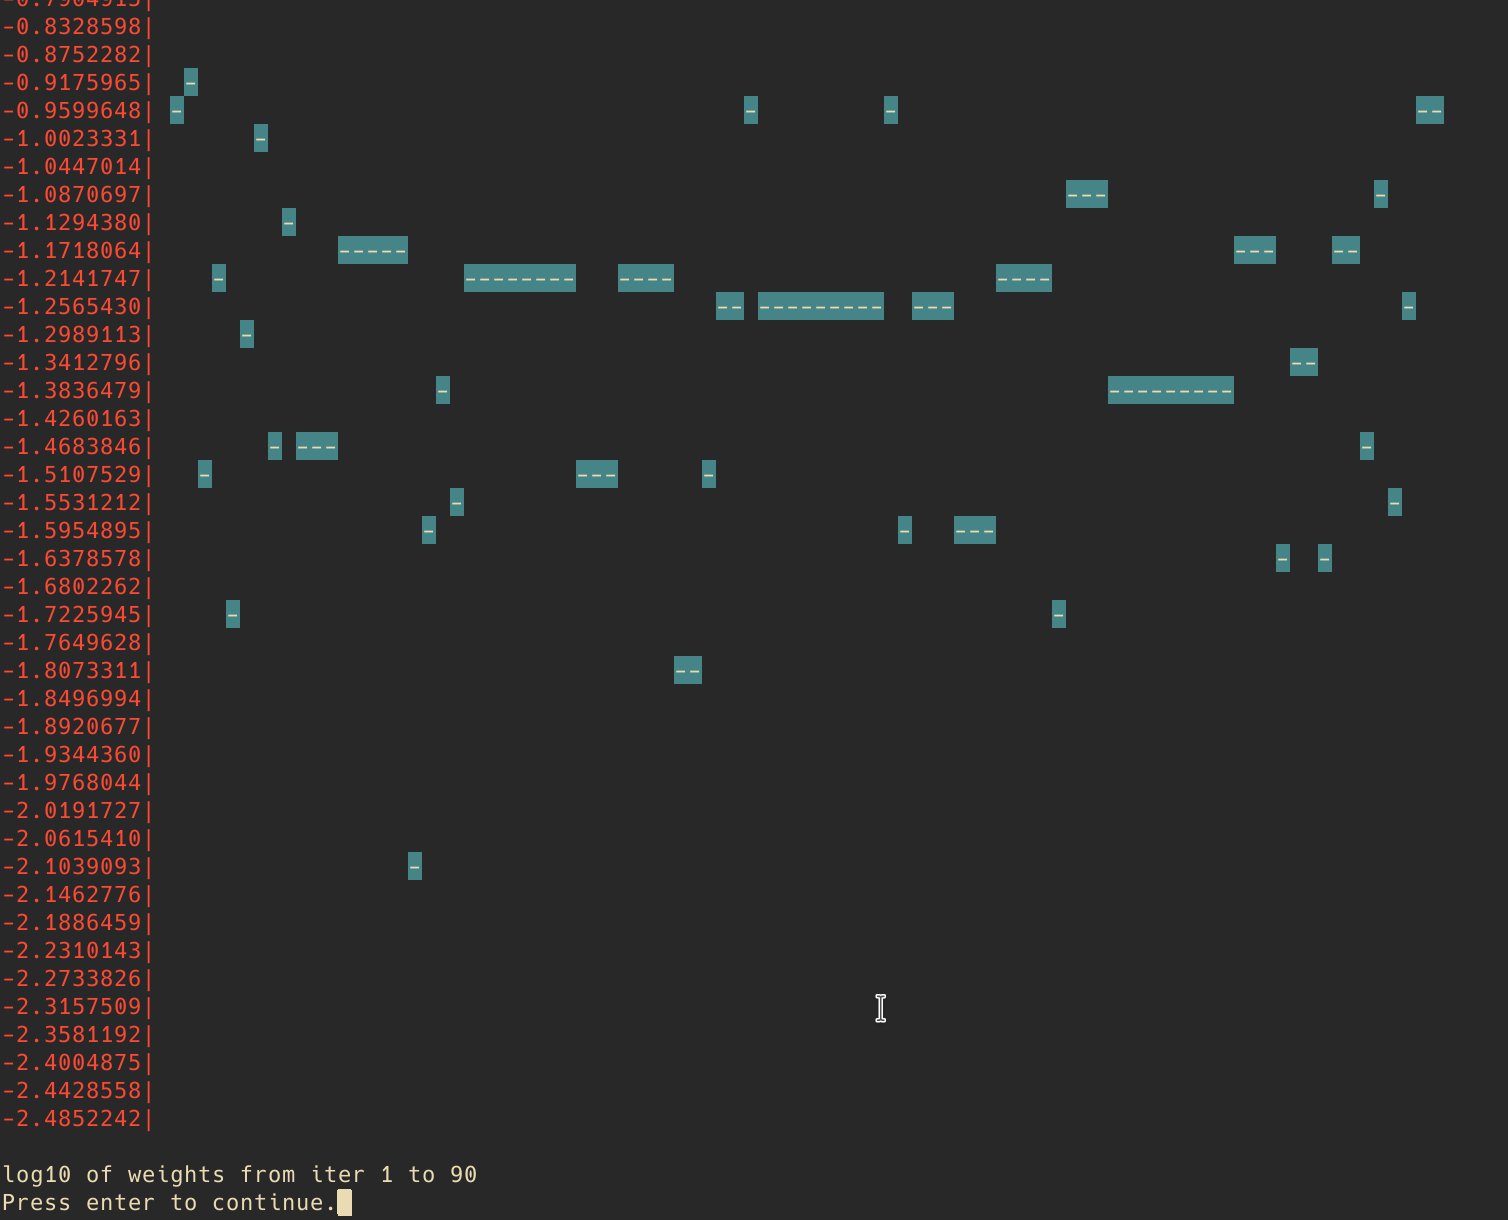

s.pcoord.plot()
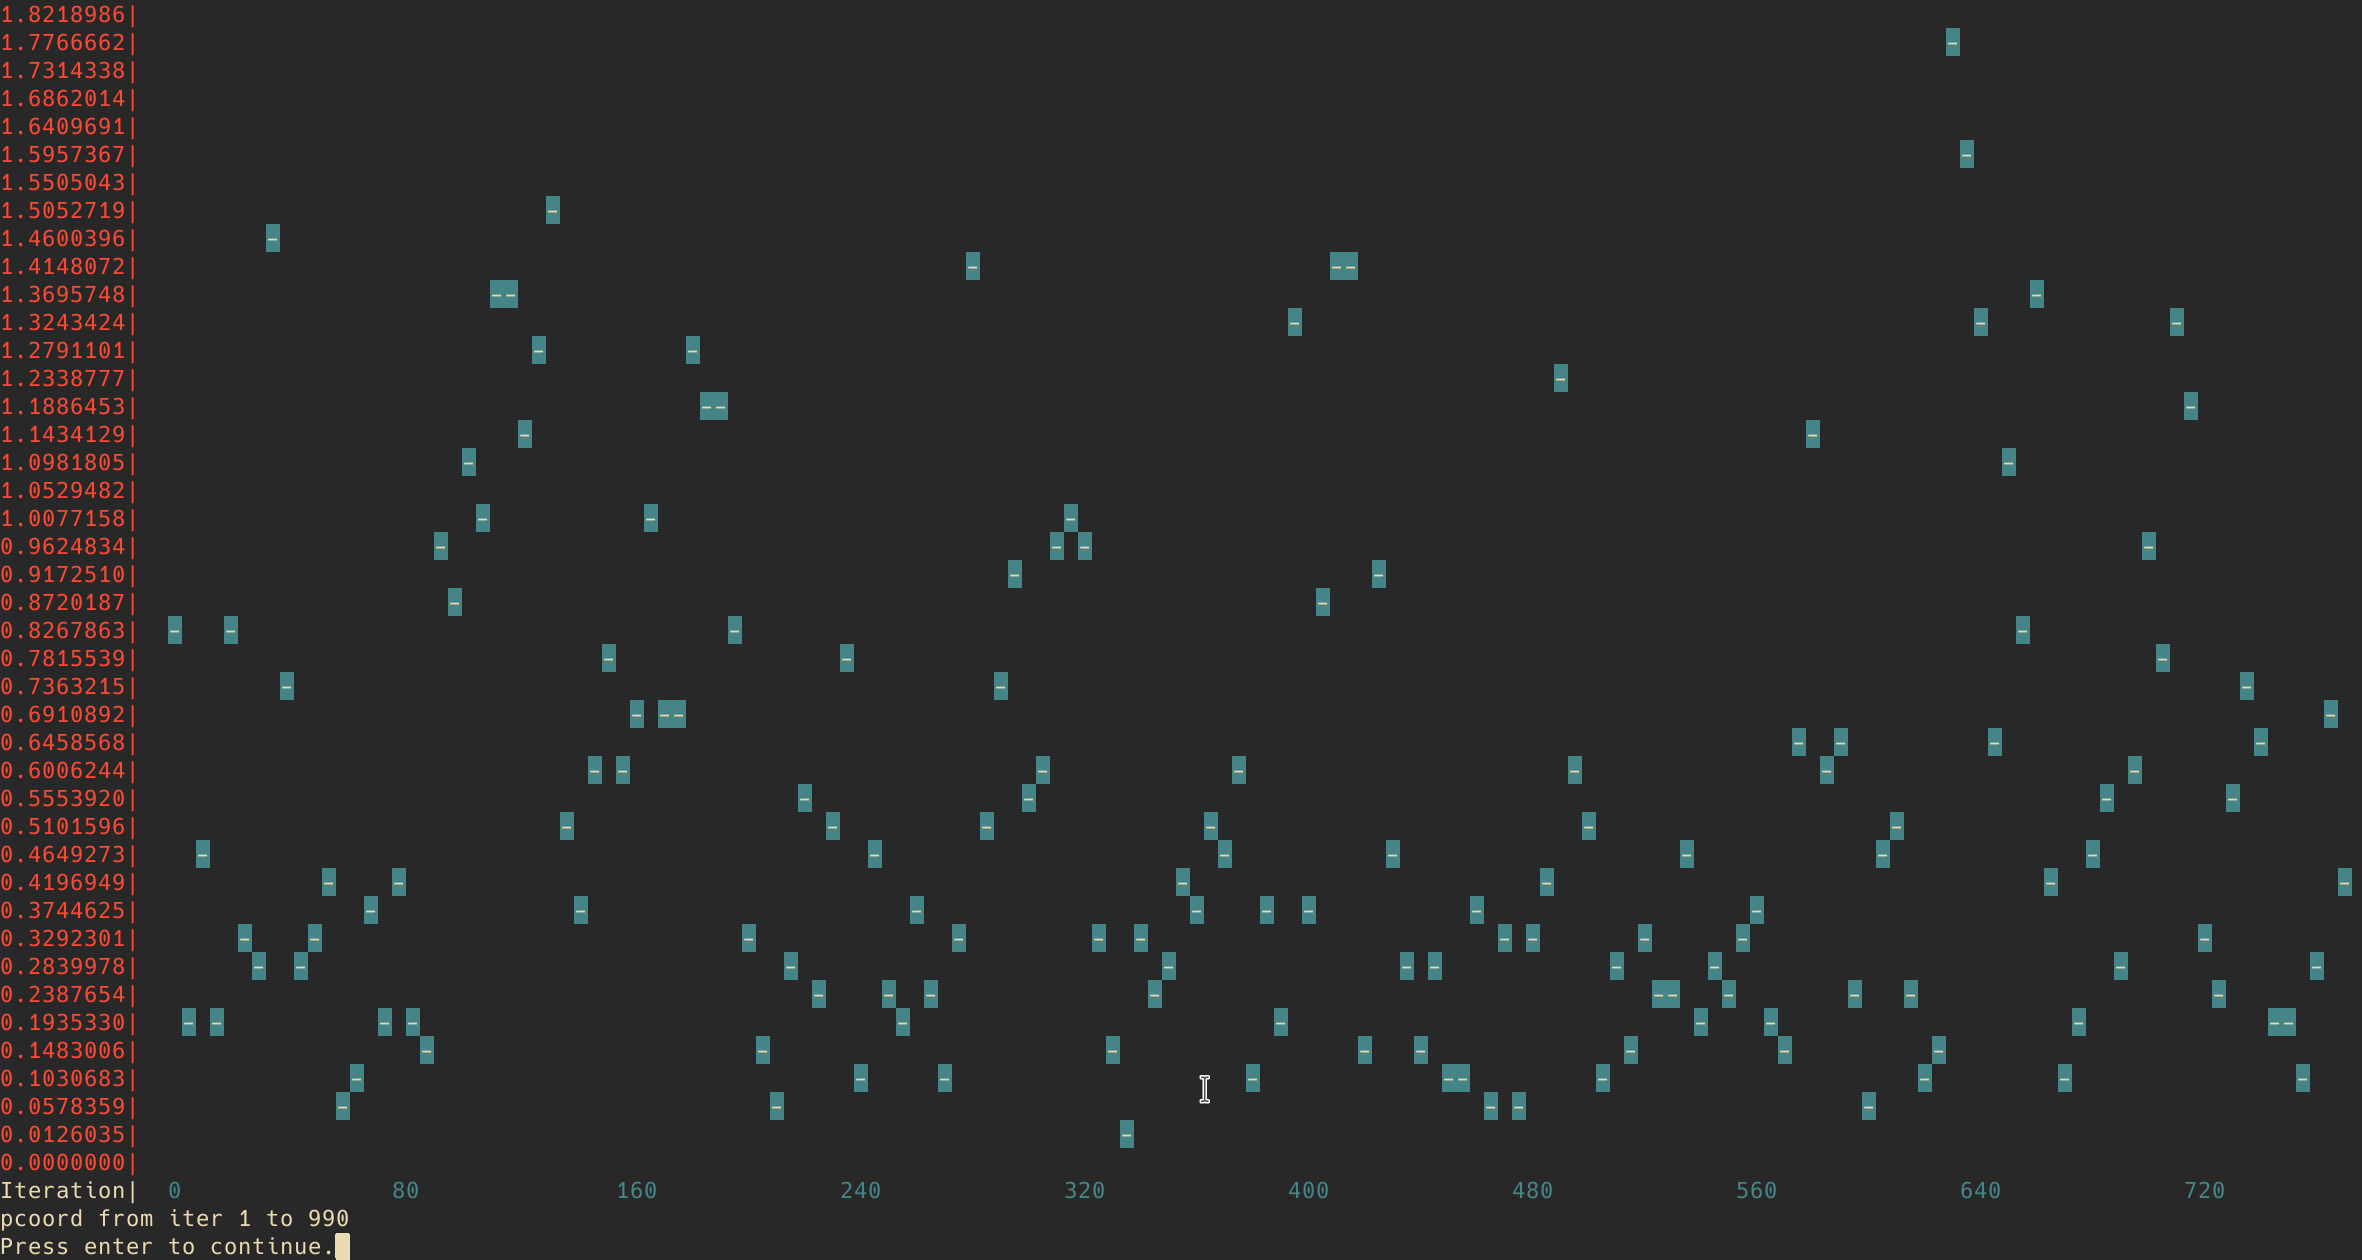

(although it says iter 1 to 990, that's a bug; there are 990 data points, which the label incorrectly states are iterations)


**<center>Can I plot the evolution of a rate constant?</center>**

Yes!

w.current contains information about your rate constant, at this current iteration, according to whatever averaging scheme you've selected.  

Run the following to see your rate constants and upper/lower CIs.  Remember that tab completion is your friend!

    w.current.direct.rate_evolution
    w.current.reweight.rate_evolution
    
or, alternatively,

    w.current.rate_evolution.direct
    w.current.rate_evolution.reweight
    
*w_ipa isn't too picky about the order of a lot of things.*

In [46]:
w.current.direct.rate_evolution

rate_evolution data:
unbound -> bound  : mean=0.000000000000000e+00 CI=(0.000000000000000e+00, 0.000000000000000e+00) * tau^-1
bound   -> unbound: mean=6.226638166338148e-05 CI=(4.296496971020543e-05, 8.367173429386358e-05) * tau^-1
To access data, index via the following names:
['ci_lbound', 'ci_ubound', 'corr_len', 'error', 'expected', 'iter_start', 'iter_stop', 'name', 'plot', 'raw', 'sterr']

We have an estimate for our bound to unbound rate constant!  That's great.  To plot it, simply call the plot function on the rate_evolution object, and send in the arguments (1,0), as otherwise it defaults to plotting the 0 to 1 rate constant

    clear
    w.current.direct.rate_evolution.plot(1,0)
    
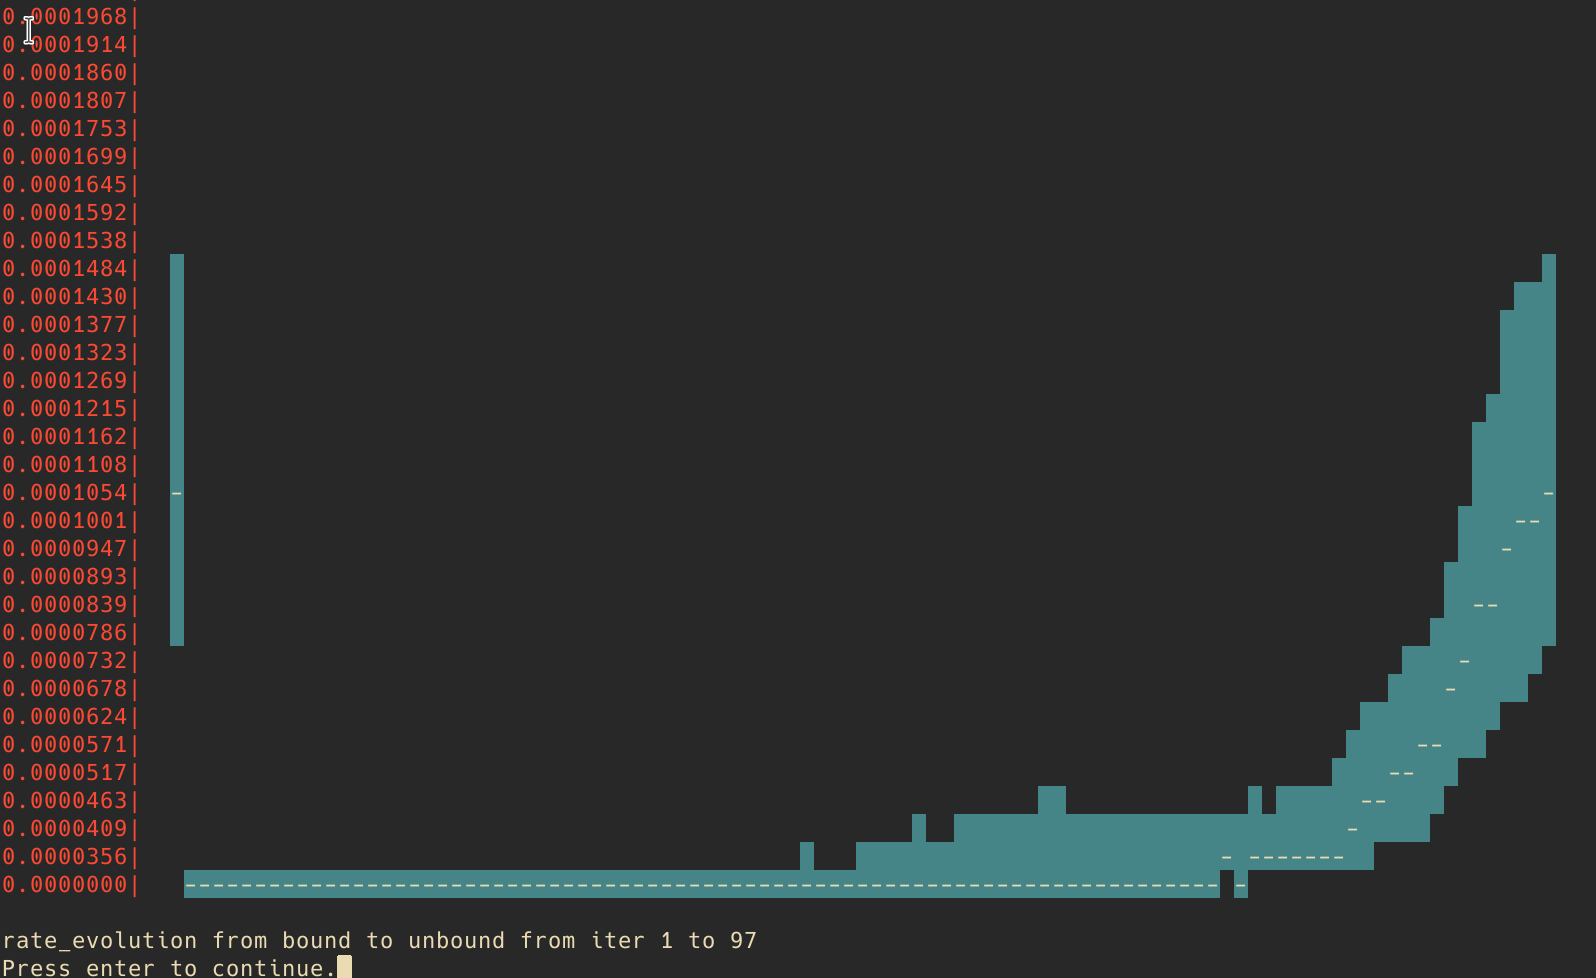
    
    
w_ipa tries to be clever and show the upper and lower CI on the plot, as well.

You can do the same with the 'reweight' dataset, but the simulation is not well sampled enough to obtain an estimate this way.  *Try running it with the full dataset at home*

**<center>What if I want to compare the rate constant estimates from two analysis schemes?</center>**

This is also easy!  You can access the current/past/future objects from different analysis schemes directly.  We have two schemes defined in our west.cfg file: CANONICAL and WORKSHOP.  You can access them from the w.scheme object:

    w.scheme.CANONICAL.current
    w.scheme.WORKSHOP.current
    
You can simply type `w.scheme`, and, without hitting enter, hit tab to show a list of the available scheme names.

To print out the estimates for the rate constants:

    w.scheme.CANONICAL.current.direct.rate_evolution
    w.scheme.WORKSHOP.current.direct.rate_evolution

In [47]:
w.scheme.CANONICAL.current.direct.rate_evolution

rate_evolution data:
unbound -> bound  : mean=0.000000000000000e+00 CI=(0.000000000000000e+00, 0.000000000000000e+00) * tau^-1
bound   -> unbound: mean=6.226638166338148e-05 CI=(4.296496971020543e-05, 8.367173429386358e-05) * tau^-1
To access data, index via the following names:
['ci_lbound', 'ci_ubound', 'corr_len', 'error', 'expected', 'iter_start', 'iter_stop', 'name', 'plot', 'raw', 'sterr']

In [48]:
w.scheme.WORKSHOP.current.direct.rate_evolution

rate_evolution data:
unbound -> bound  : mean=0.000000000000000e+00 CI=(0.000000000000000e+00, 0.000000000000000e+00) * tau^-1
bound   -> unbound: mean=1.258646169434893e-04 CI=(1.258646169434893e-04, 1.258646169434893e-04) * tau^-1
To access data, index via the following names:
['ci_lbound', 'ci_ubound', 'corr_len', 'error', 'expected', 'iter_start', 'iter_stop', 'name', 'plot', 'raw', 'sterr']

The state definitions used are the same, but our simulation is short and the error analysis stochastic; our simulation definitely needs more time!

There's a lot more to explore in w_ipa; you can also use it inside of a jupyter notebook if your west.h5 file is on your local machine.

While we can't do it today, try it on a mac (no X required) or a linux machine with Xorg and WESTPA installed.  Clone this repository again, and:

cd westpa2018analysis
w_jupyter

Then click "tutorial.ipynb" to get started!

In [ ]:
**<center>Questions?</center>**